In [1]:
# Imports

import numpy as np
import pandas as pd
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import scipy.stats
import sys
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count() - 1)
from scipy.sparse import csr_matrix

# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
        
# Extract data in df form and as a sparse matrix

dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max(df[c].max() for df in (dftrain, dftest) for c in ['sender', 'receiver'])
dim += 1

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
train_csc = train_csr.tocsc()

# As a NetworkX graph

import networkx as nx
import scipy
G = nx.from_scipy_sparse_matrix(train_csr, parallel_edges=False, create_using=nx.DiGraph())

Exploratory data analysis

count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64


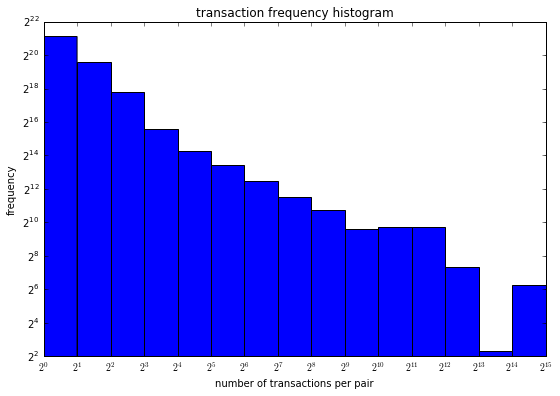

In [38]:
# Time data is not present. Thus, we'll be inferring probability of interaction
# as a stationary distribution over time, informed by the number of iteractions in the past.
series = dftrain['transaction']
title = 'transaction frequency histogram'
xlb = 'number of transactions per pair'
ylb = 'frequency'

print(series.describe())

def maxlgbin(series): return math.ceil(np.log2(series.max()))
bins = range(maxlgbin(series))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(series.apply(np.log2), bins=bins)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [29]:
n_sender = dftrain['sender'].unique().size
n_receiver = dftrain['receiver'].unique().size
n_nonmissing = dftrain['transaction'].count()
sparsity = 1 - n_nonmissing*1.0/n_sender/n_receiver
for i in ['n_sender', 'n_receiver', 'n_nonmissing', 'sparsity']: print(i, eval(i))

n_sender 443652
n_receiver 439602
n_nonmissing 3348026
sparsity 0.999982833304


count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64


AttributeError: 'tuple' object has no attribute 'get_label'

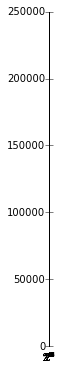

In [40]:
# Direction of edges is sender -> receiver
send_distribution = pd.Series(np.squeeze(np.asarray(train_csr.sum(0))))
recv_distribution = pd.Series(np.squeeze(np.asarray(train_csc.sum(0))))
title = 'outdegree/indegree distribution'
xlb = 'directed edge count'
ylb = 'frequency'

print(series.describe())

# http://stackoverflow.com/questions/7694298/how-to-make-a-log-log-histogram-in-python
bins = range(max(maxlgbin(x) for x in (send_distribution, recv_distribution)))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
send = plt.hist(send_distribution.apply(np.log2), bins=bins, label='out', alpha=0.75)
recv = plt.hist(recv_distribution.apply(np.log2), bins=bins, label='in', alpha=0.65)
plt.legend(handles=[send,recv])
plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

count    444075.000000
mean         35.628898
std        2067.872587
min           0.000000
25%           4.000000
50%           5.000000
75%           8.000000
max      742100.000000
dtype: float64


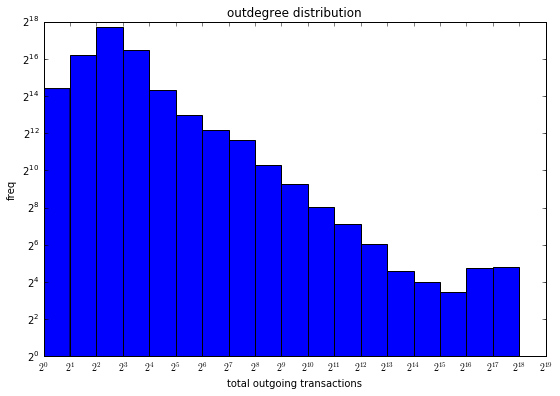

In [31]:
send_distribution = pd.Series(np.squeeze(np.asarray(train_csc.sum(0))))
describe_logloghist(send_distribution, 'indegree distribution',
                    'total outgoing transactions', 'freq')

In [ ]:
# Graph analysis (USE NetworkX)
# Look at indegree / outdegree distribution
# Edges / vertices ratio
# global cluster coefficents
# graph assortrativity
# (Takes and Kosters 2013) http://www.mdpi.com/1999-4893/6/1/100/htm
# Sample a distribution (q = 0.1) for these metrics for each vertex
# local cluster coefficients, vertex eccentricity, vertex connectivity, closeness centrality
# betweeness centrality, graph recopricity

# look at vertex correlations within clusters -> define clustering algorithm based on this.
# cosine, corr similarity ok (dispels frequency info, intentionally)
# discrete similarity metrics
# jaccard is good for intersection / union (multi-intersection / multi-union?)
# dice is the same as above.

In [ ]:
#1. linkpred -> figure out what this actually does
# Overall similarity-based algorithm: for undirected (Nowell Kleinberg 2007) - only works for undirected
# AA approach.
#2. graphsim -> can't use similarity(a, b) to predict interaction, but can use similarities to
# predict interaction x -> b) given interaction (x -> a) exists + outward. simrank (https://en.wikipedia.org/wiki/SimRank)
# (https://pypi.python.org/pypi/graphsim) need to find a paper for simrank to cite
# 3. Clustering -> do a coarser clustering by deleting "tenuous" edges, smarter prediction on the cluster.
# (Liben-Nowell and Kleninberg 2007)
# 4. low-rank approximation (paper above works, any other papers for)
# setup CV to evaluate all of these.
# look into NetworkX prediction

Various attempted methods

In [ ]:
# Create a simple CV scheme (relying on our time-stationarity assumption)
# for evaluation.

# The predictor to cross-validate, f, should accept a CSR matrix with historical interaction
# counts and output a 
# TODO: can't do CV easily - don't have temporal info



In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)
u, s, vt = svds(train_csr, k=10, tol=1e-10, which = 'LM')
pred = [np.sum(u[row['sender'],:] * s * vt[:,row['receiver']]) 
        for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('Area under the ROC curve', roc_auc)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()